In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

import random
from collections import defaultdict

%matplotlib inline

In [2]:
DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness"

In [3]:
YEAR = 2019
raw_tournament_df = pd.read_csv(f"{DATA_DIR}/output/teams.csv")
tournament_df = raw_tournament_df[raw_tournament_df["Season"] == YEAR]
tournament_df

,Season,TeamID,TeamName,Seed,SeedInt,OwnScore_Zscore,OppScore_Zscore,Offense,Dominance,Competition,OffSOS,DefSOS,OffCompetition,DefCompetition,Wins
0,2019,1101,Abilene Chr,Y15,15,-0.021108,-0.375821,-0.396929,0.354714,-0.170143,-0.237837,0.143697,-0.084784,0.085359,0.0
42,2019,1113,Arizona St,X11a,11,0.540309,-0.020030,0.520279,0.560339,0.136214,0.115382,-0.076091,0.086778,-0.049437,0.0
54,2019,1120,Auburn,Y05,5,0.668713,-0.330004,0.338709,0.998717,0.237848,0.129953,-0.217508,0.128332,-0.109516,4.0
65,2019,1124,Baylor,X09,9,0.171236,-0.367754,-0.196518,0.538990,0.216487,0.115806,-0.195033,0.088761,-0.127726,1.0
73,2019,1125,Belmont,W11a,11,1.075292,-0.026807,1.048486,1.102099,-0.074059,0.020918,0.166715,0.012259,0.086318,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,2019,1439,Virginia Tech,W04,4,0.306598,-0.752115,-0.445517,1.058713,0.222430,0.104861,-0.205388,0.099819,-0.122611,2.0
1055,2019,1449,Washington,Y09,9,-0.083146,-0.713522,-0.796668,0.630376,0.120946,0.097872,-0.138675,0.065984,-0.054961,1.0
1107,2019,1458,Wisconsin,Z05,5,-0.115887,-0.929001,-1.044888,0.813113,0.254171,0.217514,-0.169403,0.083707,-0.170464,0.0
1112,2019,1459,Wofford,Y07,7,0.598993,-0.527340,0.071653,1.126333,0.086477,0.072227,0.039000,0.076611,-0.009866,1.0


In [4]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
# Get slots, and order with play ins first
slots_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneySlots.csv")
slots_df = slots_df[slots_df["Season"] == YEAR]
slots_df = pd.concat([
    slots_df[~slots_df["Slot"].str.startswith("R")],
    slots_df[slots_df["Slot"].str.startswith("R")]
])
slots_df

,Season,Slot,StrongSeed,WeakSeed
2247,2019,W11,W11a,W11b
2248,2019,W16,W16a,W16b
2249,2019,X11,X11a,X11b
2250,2019,X16,X16a,X16b
2184,2019,R1W1,W01,W16
...,...,...,...,...
2242,2019,R4Y1,R3Y1,R3Y2
2243,2019,R4Z1,R3Z1,R3Z2
2244,2019,R5WX,R4W1,R4X1
2245,2019,R5YZ,R4Y1,R4Z1


In [5]:
games_df = pd.read_csv(f"{DATA_DIR}/output/games_training.csv")
games_df

,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OwnScore_Zscore_B,OppScore_Zscore_A,OppScore_Zscore_B,Offense_A,Offense_B,Dominance_A,Dominance_B,Competition_A,Competition_B,OffCompetition_A,OffCompetition_B,DefCompetition_A,DefCompetition_B,Win_A
0,2003,1104,1328,0.144799,0.207507,-0.335313,-0.863963,-0.190514,-0.656456,0.480112,1.071470,0.256572,0.230020,0.115030,0.100391,-0.141541,-0.129629,True
1,2003,1328,1400,0.207507,0.935597,-0.863963,-0.181307,-0.656456,0.754290,1.071470,1.116904,0.230020,0.246883,0.100391,0.120164,-0.129629,-0.126718,False
2,2003,1328,1400,0.207507,0.935597,-0.863963,-0.181307,-0.656456,0.754290,1.071470,1.116904,0.230020,0.246883,0.100391,0.120164,-0.129629,-0.126718,False
3,2003,1281,1328,0.297116,0.207507,-0.342031,-0.863963,-0.044915,-0.656456,0.639147,1.071470,0.236059,0.230020,0.115393,0.100391,-0.120666,-0.129629,True
4,2003,1328,1329,0.207507,-0.064060,-0.863963,-0.740947,-0.656456,-0.805007,1.071470,0.676887,0.230020,0.227365,0.100391,0.107095,-0.129629,-0.120270,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92827,2020,1460,1464,0.580601,-0.105439,0.198484,0.096059,0.779084,-0.009380,0.382117,-0.201498,-0.119345,-0.122204,-0.036692,-0.046344,0.082652,0.075861,False
92828,2020,1227,1460,-0.313002,0.580601,-0.164300,0.198484,-0.477301,0.779084,-0.148702,0.382117,-0.127416,-0.119345,-0.038401,-0.036692,0.089015,0.082652,True
92829,2020,1227,1460,-0.313002,0.580601,-0.164300,0.198484,-0.477301,0.779084,-0.148702,0.382117,-0.127416,-0.119345,-0.038401,-0.036692,0.089015,0.082652,True
92830,2020,1232,1460,0.095964,0.580601,-0.190164,0.198484,-0.094200,0.779084,0.286128,0.382117,0.021412,-0.119345,-0.006715,-0.036692,-0.028127,0.082652,True


In [6]:
# Train predictor based on derived offense and quality metrics
predict_df = games_df[[
    "OwnScore_Zscore_A", "OwnScore_Zscore_B",
    "OppScore_Zscore_A", "OppScore_Zscore_B",
    "OffCompetition_A", "OffCompetition_B",
    "DefCompetition_A", "DefCompetition_B",    
]]

scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(predict_df),
    columns=predict_df.columns
) 

reg = LogisticRegression().fit(
    data_scaled,
    games_df[["Win_A"]]
)
reg.score(
    data_scaled,
    games_df[["Win_A"]]
), reg.coef_

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.7467360392967942,
 array([[ 0.88632485, -0.88076532, -0.79245655,  0.83256199,  0.39762373,
         -0.38540686, -0.42798602,  0.41190513]]))

In [7]:
# See p-values for model
import statsmodels.api as sm
logit_model=sm.Logit(
    games_df[["Win_A"]].astype(int),
    data_scaled,
)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.498181
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Win_A   No. Observations:                92832
Model:                          Logit   Df Residuals:                    92824
Method:                           MLE   Df Model:                            7
Date:                Wed, 10 Mar 2021   Pseudo R-squ.:                  0.2809
Time:                        23:02:59   Log-Likelihood:                -46247.
converged:                       True   LL-Null:                       -64308.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
OwnScore_Zscore_A     0.8853      0.011     81.124      0.000       0.864       0.907
OwnScore

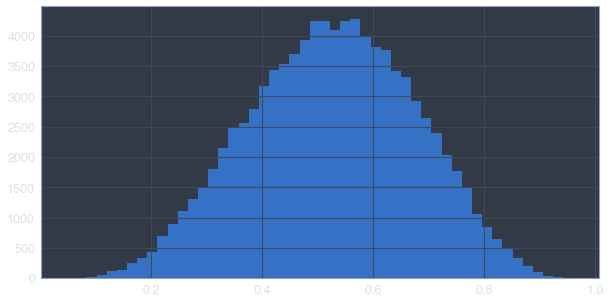

In [8]:
# Sanity check probability distribution
plt.figure(figsize=(10,5));
probs = [
    a for a, b in reg.predict_proba(predict_df)
]
plt.hist(probs, bins=50);

In [9]:
average_team = raw_tournament_df.mean().to_dict()
average_team

{'Season': 2011.095406360424,
 'TeamID': 1294.6272084805653,
 'SeedInt': 8.719081272084805,
 'OwnScore_Zscore': 0.3944827165002876,
 'OppScore_Zscore': -0.32319314544724476,
 'Offense': 0.07128957105304286,
 'Dominance': 0.7176758619475324,
 'Competition': 0.10349180833046233,
 'OffSOS': 0.07733464144482037,
 'DefSOS': -0.07592574547834176,
 'OffCompetition': 0.05262108657779809,
 'DefCompetition': -0.05087072175266421,
 'Wins': 0.946113074204947}

In [10]:
from functools import lru_cache

@lru_cache(maxsize=4096)
def calc_prob(predict_data):
    return reg.predict_proba(scaler.transform([predict_data]))[0][1]

def get_power_rating(team):
    return calc_prob((
            team["OwnScore_Zscore"], average_team["OwnScore_Zscore"],
            team["OppScore_Zscore"], average_team["OppScore_Zscore"],
            team["OffCompetition"], average_team["OffCompetition"],
            team["DefCompetition"], average_team["DefCompetition"],
        ))

In [11]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    for line in range(len(x)):
         p1.text(
             x.iloc[line]+0.02, y.iloc[line], 
             labelseries.iloc[line], size=labelsize, color=labelcolor
         )
    return p1

In [12]:
# Best teams of all time
raw_tournament_df["PowerRating"] = raw_tournament_df.apply(get_power_rating, axis=1)
raw_tournament_df["PowerOdds"] = raw_tournament_df["PowerRating"] / (1-raw_tournament_df["PowerRating"])
raw_tournament_df["PowerLogOdds"] = np.log(raw_tournament_df["PowerOdds"])

raw_tournament_df.sort_values(by="PowerRating", ascending=False)[[
    "Season", "TeamName", "Seed", "PowerRating"
]][:25]

,Season,TeamName,Seed,PowerRating
403,2015,Kentucky,Y01,0.958538
305,2019,Gonzaga,X01,0.938073
223,2019,Duke,W01,0.931571
612,2005,North Carolina,Z01,0.930417
371,2010,Kansas,Y01,0.928857
208,2004,Duke,W01,0.926187
369,2008,Kansas,X01,0.922872
1030,2019,Virginia,Z01,0.919628
1021,2018,Villanova,W01,0.917202
401,2012,Kentucky,Y01,0.916671


In [13]:
raw_tournament_df.groupby("Season").mean()[[
    "Dominance", "Competition", "PowerRating"
]]

,Dominance,Competition,PowerRating
Season,,,
2003,0.688160,0.097172,0.496259
2004,0.693042,0.096663,0.498511
2005,0.711328,0.096523,0.500627
2006,0.707615,0.093844,0.489751
2007,0.699795,0.099928,0.502849
2008,0.717957,0.093567,0.502220
2009,0.714716,0.107615,0.508781
2010,0.783524,0.106003,0.540572
2011,0.719389,0.113629,0.525387


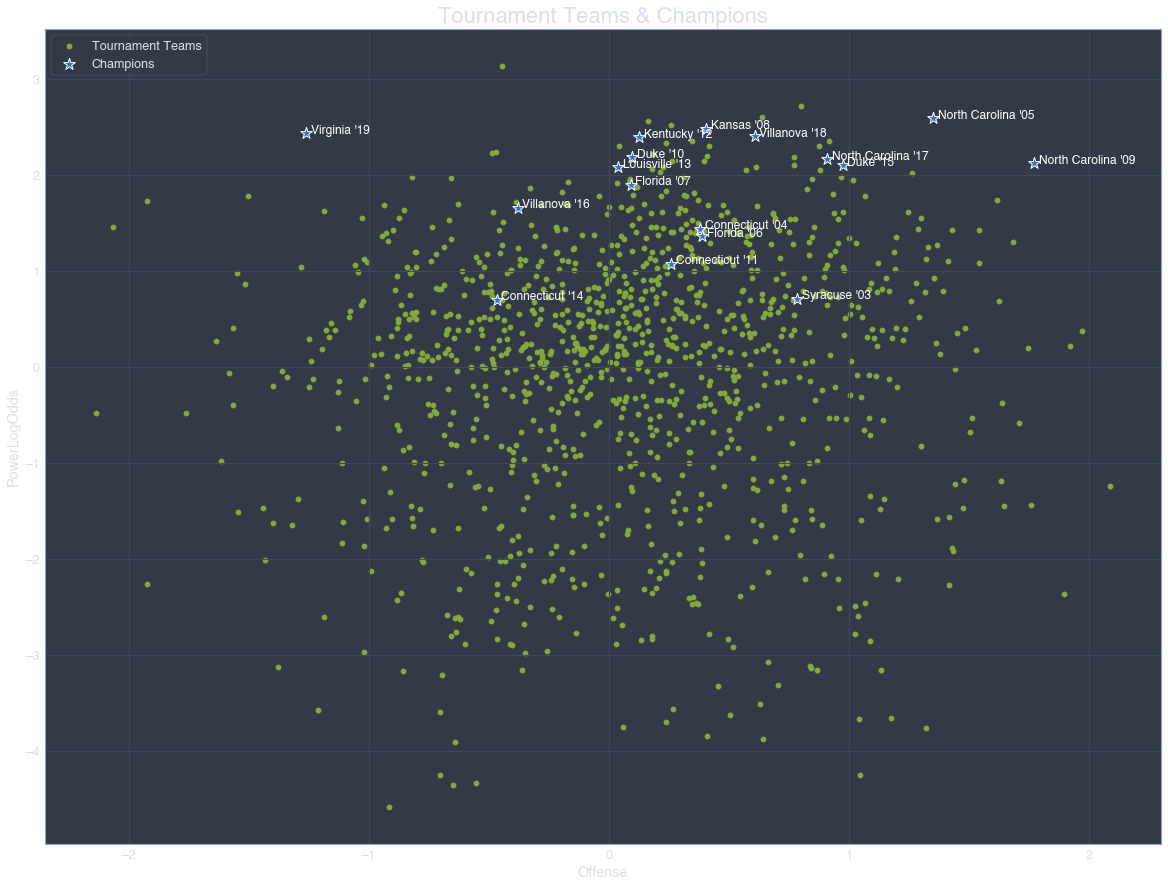

In [14]:
is_champion = raw_tournament_df["Wins"] >= 6
label_series = (
    raw_tournament_df[is_champion]["TeamName"] + " '" +
    raw_tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("Tournament Teams & Champions", fontsize=22)
plt.scatter(
    raw_tournament_df["Offense"], raw_tournament_df["PowerLogOdds"], color='g', label='Tournament Teams');
scatter_text(
    raw_tournament_df[is_champion]["Offense"], raw_tournament_df[is_champion]["PowerLogOdds"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

In [15]:
power_ratings = {}
slots_wins = defaultdict(lambda: defaultdict(int))
total_stats = defaultdict(lambda: defaultdict(int))
simulation_progression = []

SIMULATION_ROUNDS = 5000
SIM_MOD = SIMULATION_ROUNDS / 10
TOP_N = 5
for i in tqdm(range(SIMULATION_ROUNDS)):
    # INITIALIZE BRACKET (will be updated durign simulation)
    slots_dict = {
        row["Seed"]: row
        for _, row in tournament_df.iterrows()
    }
    
    for _, r in slots_df.iterrows():
        team_a = slots_dict[r["StrongSeed"]]
        team_b = slots_dict[r["WeakSeed"]]
        predict_data = (
            team_a["OwnScore_Zscore"], team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"], team_b["OppScore_Zscore"],
            team_a["OffCompetition"], team_b["OffCompetition"],
            team_a["DefCompetition"], team_b["DefCompetition"],
        )
        prob = calc_prob(predict_data)
        winning_team = team_a if random.random() < prob else team_b
        slots_dict[r["Slot"]] = winning_team
        slots_wins[r["Slot"]][winning_team["TeamID"]] += 1
        total_stats[winning_team["TeamID"]]["wins"] += 1
        if r["Slot"][1] == "3":
            total_stats[winning_team["TeamID"]]["elite8"] += 1
        if r["Slot"][1] == "4":
            total_stats[winning_team["TeamID"]]["final4"] += 1
        
        # Get "difficulty" by looking at opposing power ratings
        power_a = get_power_rating(team_a)
        power_ratings[team_a["TeamID"]] = power_a
        total_stats[team_b["TeamID"]]["opp_power"] += power_a
        total_stats[team_b["TeamID"]]["opp_power_count"] += 1
        
        power_b = get_power_rating(team_b)
        power_ratings[team_b["TeamID"]] = power_b
        total_stats[team_a["TeamID"]]["opp_power"] += power_b
        total_stats[team_a["TeamID"]]["opp_power_count"] += 1
    
    # last winning team is champion
    total_stats[winning_team["TeamID"]]["championships"] +=1
    
    # Track top teams
    if (len(total_stats) > TOP_N) and ((i + 1) % SIM_MOD == 0):
        teams_by_championships = sorted(
            total_stats.items(), key=lambda x: x[1]["championships"], reverse=True
        )
        for team_id, stats in teams_by_championships[:TOP_N]:
            simulation_progression.append({
                "TeamID": team_id,
                "PercentChampion": stats["championships"] / (i + 1),
                "Rounds": i + 1
            })

100%|██████████| 5000/5000 [00:45<00:00, 109.34it/s]


In [16]:
power_df = pd.DataFrame([{"TeamID": k, "PowerRating": v} for k, v in power_ratings.items()])
tournament_df = tournament_df.merge(power_df, on="TeamID")

In [17]:
simulation_df = pd.DataFrame([
    {
        "TeamID": team_id,
        "AvgOppPower": results_dict["opp_power"] / results_dict["opp_power_count"],
        "MeanWins": results_dict["wins"] / SIMULATION_ROUNDS,
        "PercentElite8": results_dict["elite8"] / SIMULATION_ROUNDS,
        "PercentFinal4": results_dict["final4"] / SIMULATION_ROUNDS,
        "PercentChampion": results_dict["championships"] / SIMULATION_ROUNDS
    }
    for team_id, results_dict in total_stats.items()
])
simulation_df = simulation_df.merge(tournament_df, on="TeamID")[[
    "TeamID", "TeamName", "Seed",
    "OwnScore_Zscore",
    "OppScore_Zscore",
    "Offense",
    "Dominance",
    "Competition",
    "AvgOppPower",
    "PowerRating",
    "MeanWins",
    "PercentElite8",
    "PercentFinal4",
    "PercentChampion",
    "Wins"
]]

In [18]:
simulation_df["LogOdds"] = np.log(
    simulation_df["PercentChampion"] / (1-simulation_df["PercentChampion"])
).replace([np.inf, -np.inf], np.nan)
simulation_df["LogOdds"] = simulation_df["LogOdds"].fillna(simulation_df["LogOdds"].min())

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


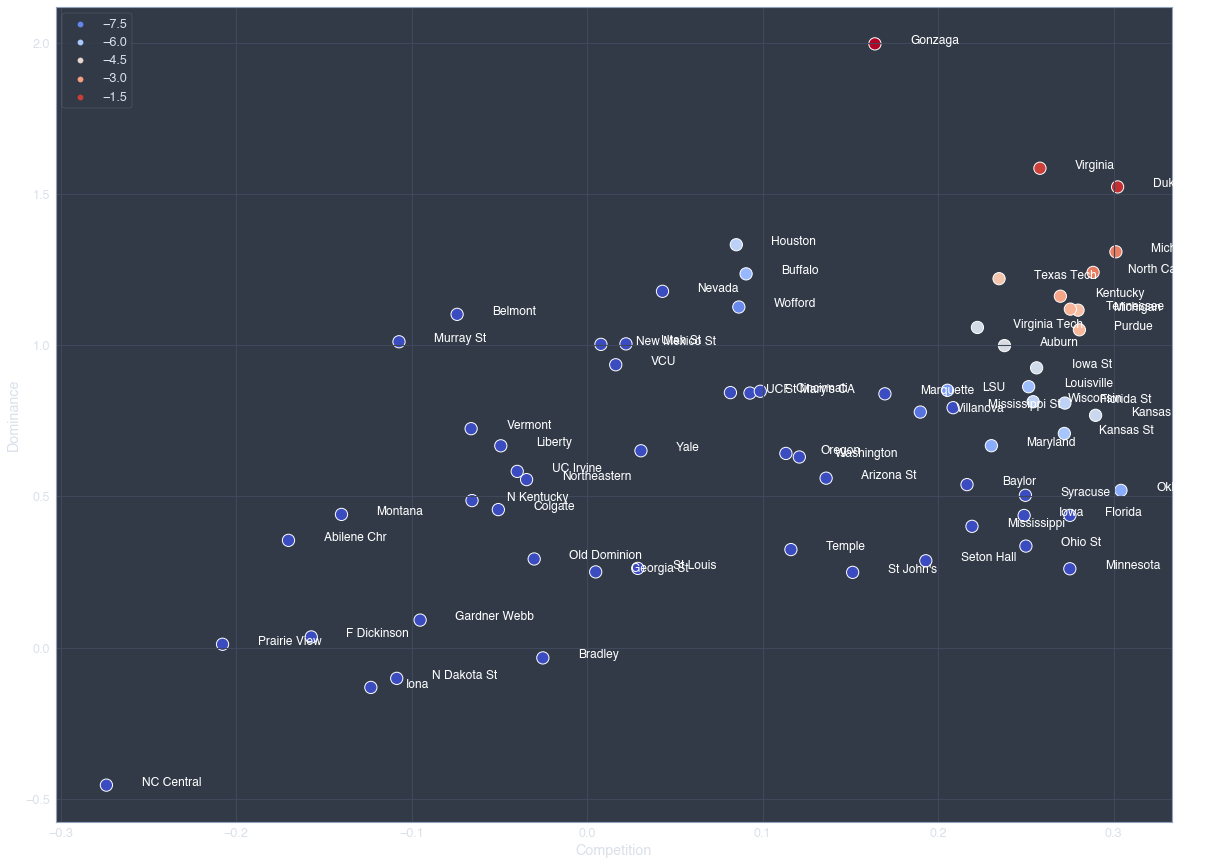

In [19]:
plt.figure(figsize=(20,15));
scatter_text(
    x=simulation_df["Competition"], y=simulation_df["Dominance"], s=150,
    hue=simulation_df["LogOdds"],
    palette=sns.color_palette("coolwarm", as_cmap=True),
    labelseries=simulation_df["TeamName"], labelcolor="white",
);
plt.legend(loc='upper left');

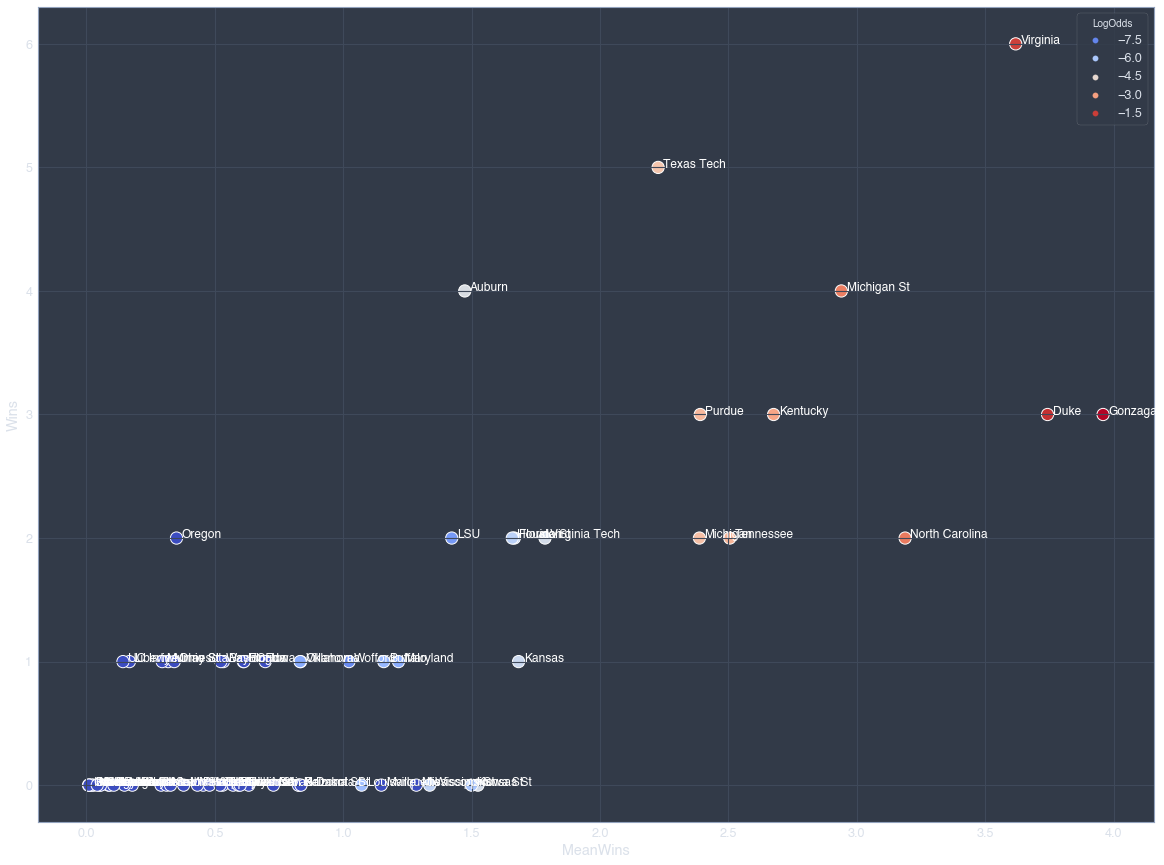

In [20]:
plt.figure(figsize=(20,15));
scatter_text(
    x=simulation_df["MeanWins"], y=simulation_df["Wins"], s=150,
    hue=simulation_df["LogOdds"], palette=sns.color_palette("coolwarm", as_cmap=True),
    labelseries=simulation_df["TeamName"], labelcolor="white"
);

In [21]:
BASIC_COLUMNS = ["TeamName", "Seed", "MeanWins", "PercentElite8", "PercentFinal4", "PercentChampion"]

In [22]:
# Who is the best team?
simulation_df.sort_values("PowerRating", ascending=False)[["PowerRating"] + BASIC_COLUMNS][:30]

,PowerRating,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion
22,0.938073,Gonzaga,X01,3.9586,0.7936,0.6086,0.2634
8,0.931571,Duke,W01,3.7424,0.7674,0.5318,0.2044
52,0.919628,Virginia,Z01,3.6184,0.7230,0.5114,0.1746
9,0.900220,Michigan St,W02,2.9396,0.6440,0.3088,0.0804
36,0.882936,North Carolina,Y01,3.1878,0.6196,0.4024,0.0852
38,0.848128,Kentucky,Y02,2.6756,0.5010,0.2672,0.0422
23,0.844977,Michigan,X02,2.3868,0.4300,0.1582,0.0238
54,0.844600,Tennessee,Z02,2.5050,0.4508,0.1992,0.0306
25,0.837447,Texas Tech,X03,2.2260,0.3828,0.1246,0.0206
56,0.833279,Purdue,Z03,2.3900,0.4110,0.1686,0.0282


In [23]:
# Who has the easiest schedule on average (excluding play ins)
is_not_play_in =  ~simulation_df["Seed"].str[-1].apply(str.isalpha)
simulation_df[is_not_play_in].sort_values(
    "AvgOppPower", ascending=True)[["AvgOppPower"] + BASIC_COLUMNS][:16]

,AvgOppPower,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion
36,0.541134,North Carolina,Y01,3.1878,0.6196,0.4024,0.0852
40,0.542167,Houston,Y03,1.6582,0.1908,0.0630,0.0036
38,0.544500,Kentucky,Y02,2.6756,0.5010,0.2672,0.0422
58,0.548400,Kansas St,Z04,1.4996,0.1032,0.0340,0.0022
13,0.552069,Virginia Tech,W04,1.7854,0.1522,0.0654,0.0062
27,0.552095,Florida St,X04,1.6660,0.1256,0.0482,0.0038
23,0.557501,Michigan,X02,2.3868,0.4300,0.1582,0.0238
56,0.559523,Purdue,Z03,2.3900,0.4110,0.1686,0.0282
15,0.561486,Mississippi St,W05,1.2846,0.0614,0.0160,0.0002
29,0.563775,Marquette,X05,1.1480,0.0462,0.0148,0.0002


In [24]:
# Who has the best chance to win
pie_df = simulation_df.sort_values("PercentChampion", ascending=False)
pie_df[[
    "TeamName", "Seed", "PowerRating", "AvgOppPower", "PercentElite8", "PercentFinal4", "PercentChampion"
]][:10]

,TeamName,Seed,PowerRating,AvgOppPower,PercentElite8,PercentFinal4,PercentChampion
22,Gonzaga,X01,0.938073,0.588790,0.7936,0.6086,0.2634
8,Duke,W01,0.931571,0.571395,0.7674,0.5318,0.2044
52,Virginia,Z01,0.919628,0.590292,0.7230,0.5114,0.1746
36,North Carolina,Y01,0.882936,0.541134,0.6196,0.4024,0.0852
9,Michigan St,W02,0.900220,0.579847,0.6440,0.3088,0.0804
38,Kentucky,Y02,0.848128,0.544500,0.5010,0.2672,0.0422
54,Tennessee,Z02,0.844600,0.566949,0.4508,0.1992,0.0306
56,Purdue,Z03,0.833279,0.559523,0.4110,0.1686,0.0282
23,Michigan,X02,0.844977,0.557501,0.4300,0.1582,0.0238
25,Texas Tech,X03,0.837447,0.574237,0.3828,0.1246,0.0206


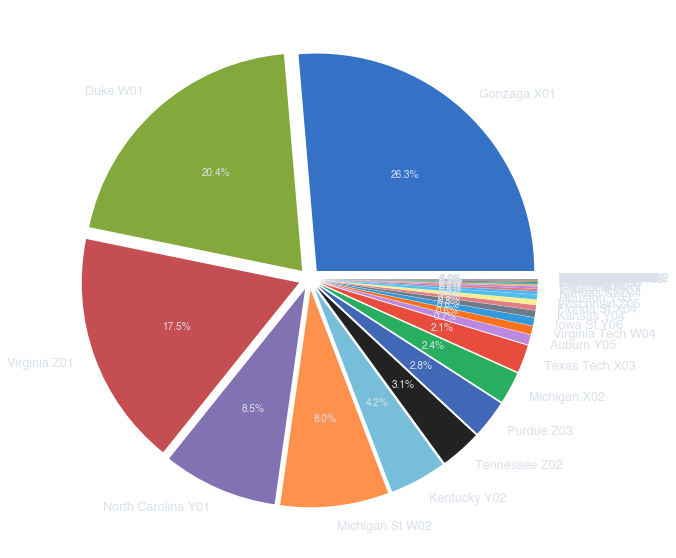

In [25]:
plt.figure(figsize=(10,10));
plt.pie(
    x=pie_df["PercentChampion"],
    labels=pie_df["TeamName"] + " " + pie_df["Seed"],
    autopct="%.1f%%",
    explode=[0.05]*len(simulation_df),
);

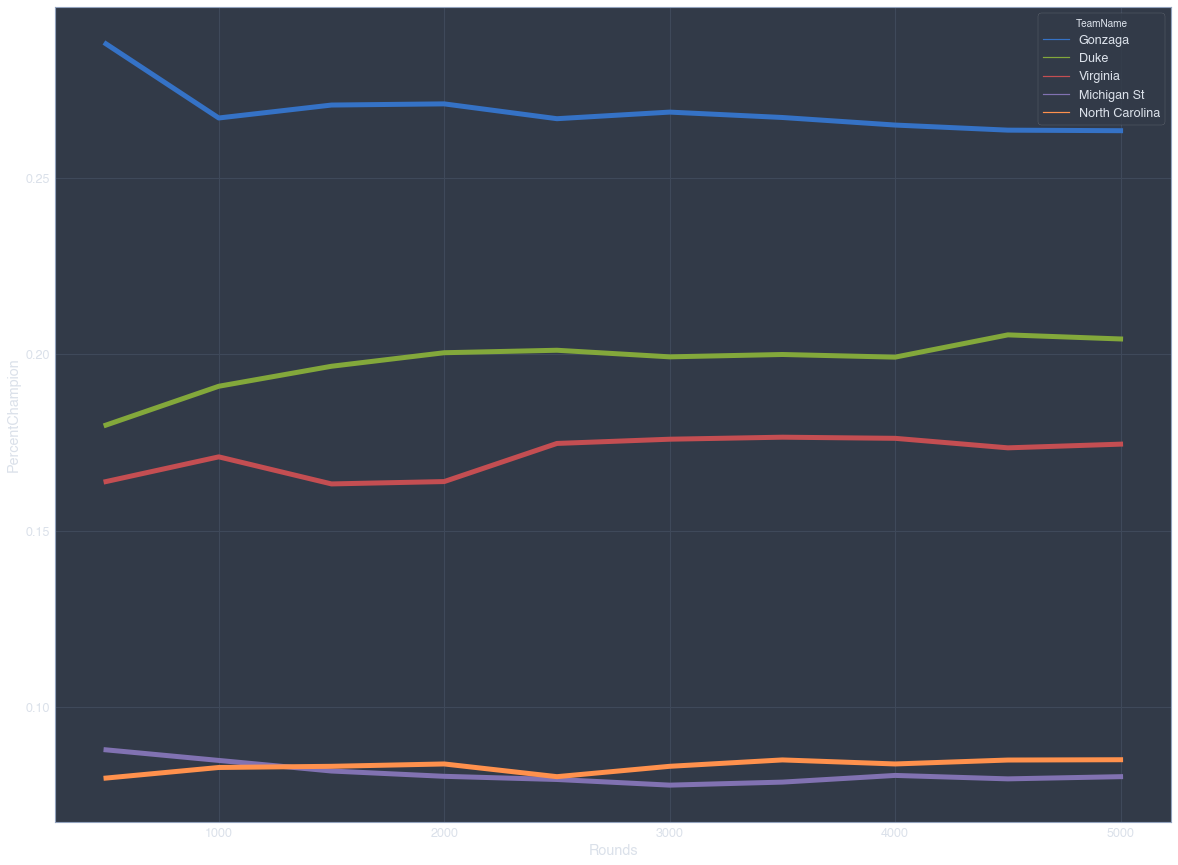

In [26]:
# Confirm % looks stable over time
plt.figure(figsize=(20,15));
progression_df = pd.DataFrame(simulation_progression).merge(
    tournament_df[["TeamID", "TeamName"]], on="TeamID"
)
sns.lineplot(
    data=progression_df,
    x="Rounds", y="PercentChampion", hue="TeamName", linewidth=5
);

In [27]:
 # What is the most common bracket?
bracket_slots = []
for slot, win_dict in slots_wins.items():
    top_teams = sorted(((v, k) for k, v in win_dict.items()), reverse=True)
    max_count, max_team_id = top_teams[0]
    runner_count, runner_team_id = top_teams[1]
    total = sum(v for v in win_dict.values())
    bracket_slots.append({
        "Slot": slot,
        "WinTeamID": max_team_id,
        "WinPct": max_count / total,
        "RunnerTeamID": runner_team_id,
        "RunnerWinPct": runner_count / total,
    })

bracket_df = pd.DataFrame(bracket_slots).merge(
    tournament_df[["TeamID", "TeamName", "Seed"]], left_on="WinTeamID", right_on="TeamID"
).rename(columns={"TeamName": "WinTeamName", "Seed": "WinSeed"}).merge(
    tournament_df[["TeamID", "TeamName", "Seed"]], left_on="RunnerTeamID", right_on="TeamID"
).rename(columns={"TeamName": "RunnerTeamName", "Seed": "RunnerSeed"})
bracket_df["Round"] = bracket_df["Slot"].apply(lambda x: int(x[1]) if x.startswith("R") else 0)
bracket_df = bracket_df[[
    "Slot", "Round",
    "WinTeamName", "WinSeed", "WinPct",
    "RunnerTeamName", "RunnerSeed", "RunnerWinPct"
]]

In [28]:
bracket_df[bracket_df["Round"] == 3].sort_values("WinPct", ascending=False)

,Slot,Round,WinTeamName,WinSeed,WinPct,RunnerTeamName,RunnerSeed,RunnerWinPct
21,R3X1,3,Gonzaga,X01,0.7936,Florida St,X04,0.1256
6,R3W1,3,Duke,W01,0.7674,Virginia Tech,W04,0.1522
53,R3Z1,3,Virginia,Z01,0.7230,Wisconsin,Z05,0.1052
10,R3W2,3,Michigan St,W02,0.6440,LSU,W03,0.1266
38,R3Y1,3,North Carolina,Y01,0.6196,Kansas,Y04,0.1762
42,R3Y2,3,Kentucky,Y02,0.5010,Iowa St,Y06,0.1992
59,R3Z2,3,Tennessee,Z02,0.4508,Purdue,Z03,0.4110
27,R3X2,3,Michigan,X02,0.4300,Texas Tech,X03,0.3828


In [29]:
# Submit to Kaggle
import itertools
predictions = []
for year in range(2015, 2020):
    submit_df = raw_tournament_df[raw_tournament_df["Season"] == year].set_index(["Season", "TeamID"])
    ids = sorted(submit_df.loc[year].index)
    for id_a, id_b in itertools.product(ids, ids):
        if id_a >= id_b:
            continue
        team_a = submit_df.loc[(year, id_a)]
        team_b = submit_df.loc[(year, id_b)]
        predict_data = (
            team_a["OwnScore_Zscore"], team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"], team_b["OppScore_Zscore"],
            team_a["OffCompetition"], team_b["OffCompetition"],
            team_a["DefCompetition"], team_b["DefCompetition"],
        )
        prob = calc_prob(predict_data)
        predictions.append({
            "ID": f"{year}_{id_a}_{id_b}",
            "Pred": prob
        })

In [30]:
pred_df = pd.DataFrame(predictions)
pred_df.to_csv(f"{DATA_DIR}/output/kaggle_submission.csv", index=False)